# 1.1. Definicja funkcji celu i jej gradientu

### Należy zdefiniować funkcję oraz jej pochodne cząstkowe (gradient).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Definicja funkcji celu dla Wariantu 4
def f_variant4(x, y):
    return x * np.exp(-x**2 - y**2)

# Definicja gradientu funkcji celu
def grad_f_variant4(x, y):
    # Pochodna po x:
    dx = np.exp(-x**2 - y**2) * (1 - 2*x**2)
    # Pochodna po y:
    dy = -2 * x * y * np.exp(-x**2 - y**2)
    return np.array([dx, dy])

## 1.2. Implementacja algorytmów optymalizacji

In [2]:
def optimize_path(opt_name, lr=0.001, steps=100):
    # Punkt startowy
    pos = np.array([0.5, 1.5])
    path = [pos.copy()]
    
    # Zmienne dla algorytmów adaptacyjnych
    v = np.zeros(2) # Momentum
    s = np.zeros(2) # RMSProp/Adam
    beta1, beta2 = 0.9, 0.999
    eps = 1e-8
    
    for t in range(1, steps + 1):
        grad = grad_f_variant4(*pos)
        
        if opt_name == 'gd':
            pos -= lr * grad
            
        elif opt_name == 'momentum':
            v = beta1 * v + (1 - beta1) * grad 
            pos -= lr * v
            
        elif opt_name == 'rmsprop':
            s = beta2 * s + (1 - beta2) * grad**2
            pos -= lr * grad / (np.sqrt(s) + eps)
            
        elif opt_name == 'adam':
            v = beta1 * v + (1 - beta1) * grad
            s = beta2 * s + (1 - beta2) * grad**2
            v_corr = v / (1 - beta1**t)
            s_corr = s / (1 - beta2**t)
            pos -= lr * v_corr / (np.sqrt(s_corr) + eps)
            
        path.append(pos.copy())
        
    return np.array(path)

## 1.3. Wizualizacja i porównanie

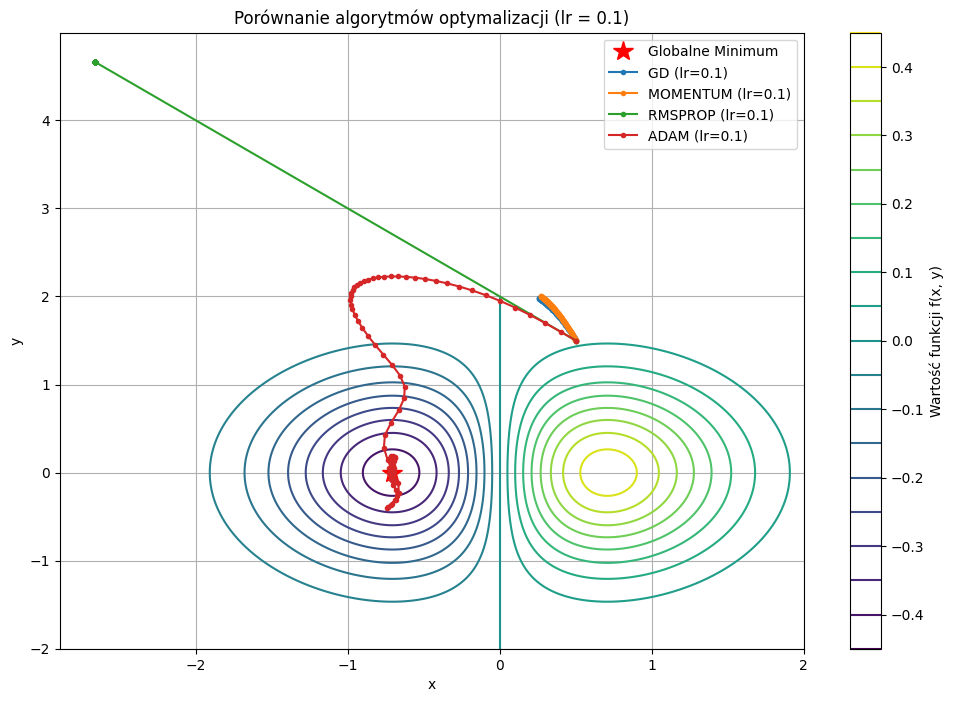

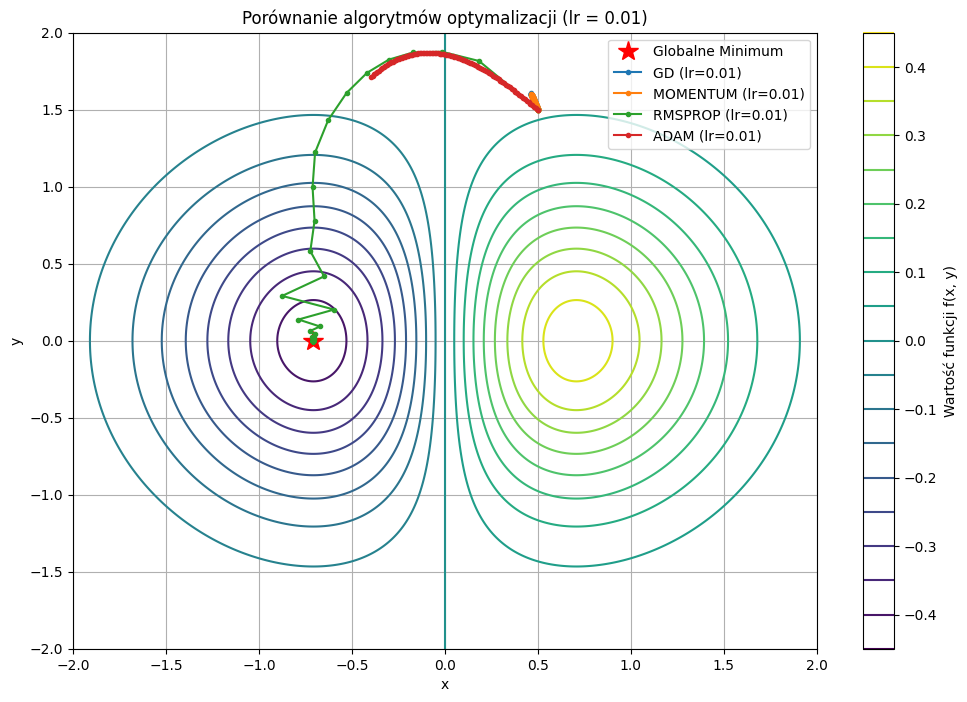

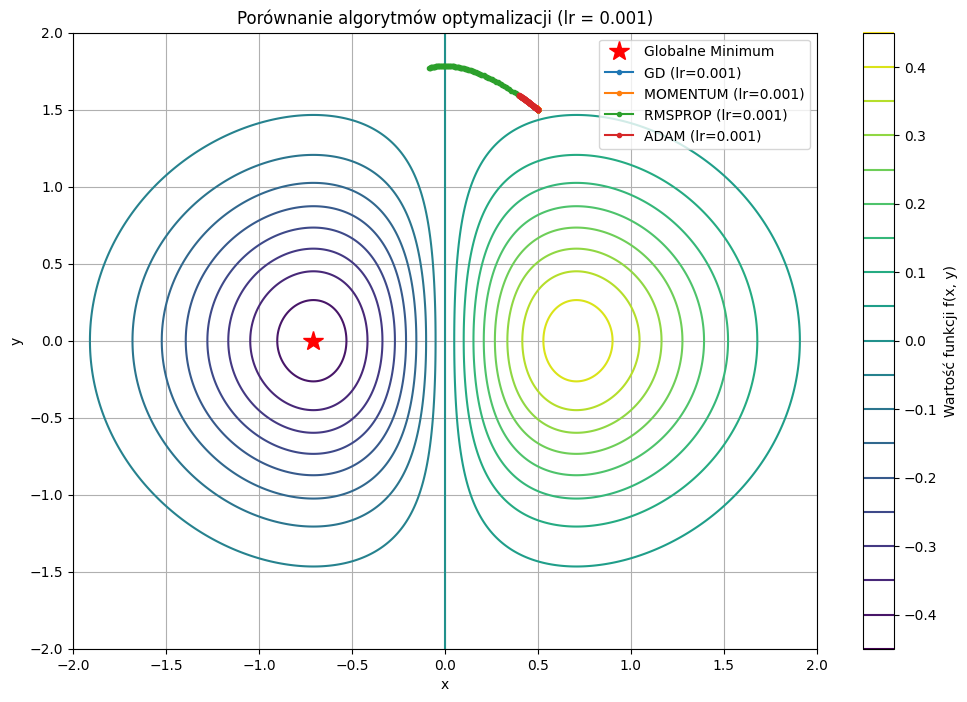

In [3]:
# Przygotowanie siatki do wizualizacji
x_space = np.linspace(-2, 2, 400)
y_space = np.linspace(-2, 2, 400)
X_mesh, Y_mesh = np.meshgrid(x_space, y_space)
Z_mesh = f_variant4(X_mesh, Y_mesh)

optimizers = ['gd', 'momentum', 'rmsprop', 'adam']
learning_rates = [0.1, 0.01, 0.001]

for lr in learning_rates:
    plt.figure(figsize=(12, 8))
    # Minimum globalne jest w punkcie (-1/sqrt(2), 0)
    plt.plot(-1/np.sqrt(2), 0, 'r*', markersize=15, label='Globalne Minimum')
    
    # Wykres konturowy funkcji celu
    plt.contour(X_mesh, Y_mesh, Z_mesh, levels=20, cmap='viridis')
    plt.colorbar(label='Wartość funkcji f(x, y)')

    for opt_name in optimizers:
        path = optimize_path(opt_name, lr=lr, steps=100)
        plt.plot(path[:, 0], path[:, 1], 'o-', label=f'{opt_name.upper()} (lr={lr})', markersize=3, linewidth=1.5)

    plt.title(f'Porównanie algorytmów optymalizacji (lr = {lr})')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    plt.show()

# Część 2: Konfiguracja TensorBoard do wizualizacji wag i gradientów

### Budowa prostej sieci neuronowej (MLP) do klasyfikacji obrazów z popularnego zbioru MNIST. Głównym celem jest skonfigurowanie narzędzia TensorBoard tak, aby śledzić nie tylko metryki takie jak strata i dokładność, ale również rozkłady wag i gradientów w każdej epoce treningu.

## 2.1. Niestandardowy callback do logowania gradientów
### Standardowy callback TensorBoard w Keras loguje wagi, ale nie gradienty. Zgodnie z instrukcją, należy utworzyć własny callback, który przy użyciu tf.GradientTape oblicza i zapisuje gradienty na koniec każdej epoki.

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models
import datetime

class GradientLoggingCallback(tf.keras.callbacks.Callback):
    def __init__(self, log_dir, validation_data):
        super().__init__()
        # Inicjalizacja writera do TensorBoard
        self.writer = tf.summary.create_file_writer(log_dir)
        # Pobranie próbki walidacyjnej do obliczania gradientów
        self.validation_sample = next(iter(validation_data.batch(128)))

    def on_epoch_end(self, epoch, logs=None):
        # Rozpakowanie próbki walidacyjnej
        x_val, y_val = self.validation_sample
        
        # Użycie GradientTape do obliczenia gradientów
        with tf.GradientTape() as tape:
            y_pred = self.model(x_val, training=False)
            loss = self.model.compiled_loss(y_val, y_pred)
        
        # Gradienty straty względem wag modelu
        gradients = tape.gradient(loss, self.model.trainable_variables)
        
        # Zapis gradientów do TensorBoard
        with self.writer.as_default():
            for weight, grad in zip(self.model.trainable_variables, gradients):
                tf.summary.histogram(
                    f"{weight.name}_grad",  
                    grad,
                    step=epoch
                )

## 2.2. Budowa, trening i monitorowanie modelu MLP

In [6]:
# 1. Przygotowanie danych MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(-1, 28 * 28) / 255.0
x_test = x_test.reshape(-1, 28 * 28) / 255.0

# Stworzenie obiektu tf.data.Dataset dla callbacka
validation_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# 2. Budowa modelu MLP
model = models.Sequential([
    layers.Input(shape=(784,)),
    layers.Dense(128, activation='relu', name='dense_1'),
    layers.Dense(64, activation='relu', name='dense_2'),
    layers.Dense(10, activation='softmax', name='output')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# 3. Konfiguracja callbacków TensorBoard
log_dir = "logs/variant4/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Standardowy callback do logowania metryk i wag
tensorboard_cb = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1  #Zapis co 1 epokę
)

# Własny callback do logowania gradientów
gradient_cb = GradientLoggingCallback(
    log_dir=log_dir,
    validation_data=validation_dataset
)

# 4. Trening modelu
print("\nRozpoczynanie treningu modelu MLP z monitorowaniem w TensorBoard...")
model.fit(x_train, y_train,
          epochs=10,
          validation_data=(x_test, y_test),
          callbacks=[tensorboard_cb, gradient_cb])

print(f"\nTrening zakończony. Logi zostały zapisane w katalogu: {log_dir}")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)


Rozpoczynanie treningu modelu MLP z monitorowaniem w TensorBoard...
Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9289 - loss: 0.2444 - val_accuracy: 0.9610 - val_loss: 0.1287
Epoch 2/10
  67/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9756 - loss: 0.1018

c:\Users\Maciek\Desktop\NaukaODanychII\.venv\Lib\site-packages\keras\src\backend\tensorflow\trainer.py:673: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight, training)`.
  warnings.warn(


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9701 - loss: 0.1006 - val_accuracy: 0.9691 - val_loss: 0.0987
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9775 - loss: 0.0725 - val_accuracy: 0.9698 - val_loss: 0.0910
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9832 - loss: 0.0533 - val_accuracy: 0.9757 - val_loss: 0.0783
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9861 - loss: 0.0437 - val_accuracy: 0.9782 - val_loss: 0.0757
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9887 - loss: 0.0351 - val_accuracy: 0.9773 - val_loss: 0.0758
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9906 - loss: 0.0291 - val_accuracy: 0.9774 - val_loss: 0.0799
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9919 - loss: 0.0253 - val_accuracy: 0.9758 - val_loss: 0.0960
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9928 - loss: 0.0222 - val_accurac